## CONSIGNA
Mediante el modelo de redes neuronales que el alumno considere pertinente, deberá resolver el problema de clasificación de rostros de Labeled Faces in the Wild (LFW) usando un sub-conjunto del dataset homónimo disponible en scikit-learn.

__Importación de librerías, carga y visualización de los datos__

In [1]:
import numpy as np 
import tensorflow as tf
import time
import sklearn
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

C:\Users\mbian\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation

from keras.metrics import MSE
from keras.optimizers import Adadelta
from keras.losses import categorical_crossentropy

from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

#---------------------------------------------------------------------------#

# Utilizaremos solo imagenes de 7 personas con mas de 70 imagenes disponibles.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5, color=False)

# Inspeccion de los tamaños
n_samples, h, w = lfw_people.images.shape

# Datos sin divir en subconjuntos
x = lfw_people.images

# Etiquetas y clases
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("h, w: (%d, %d)" % (h, w))
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)

Total dataset size:
h, w: (62, 47)
n_samples: 1288
n_classes: 7


__Seteo de hiperparámetros__

In [3]:
lr = 0.5
batch_size = 10
epochs = 15
np.random.seed(14)

__Gráfico de las imágenes__

In [4]:
# Algunas funciones para graficar
def plot_gallery(images, number, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(number):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [5]:
def title(y, target_names):
    return "%s" % (target_names[y])

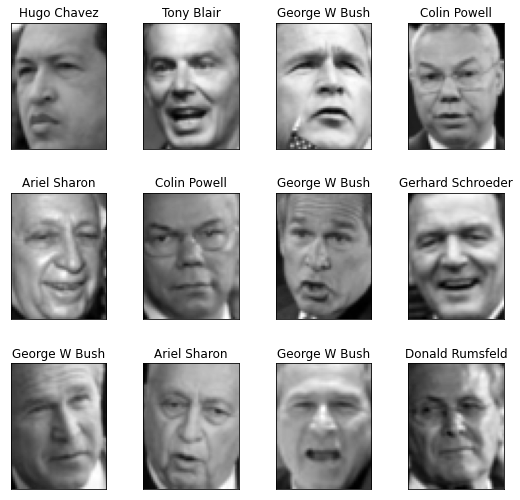

In [6]:
titles = [title(y[i], target_names) for i in range(20)]
plot_gallery(x, 12 , titles, h, w)

__División de datos__

In [7]:
#división de datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(lfw_people.images, lfw_people.target, test_size=0.3, random_state=42)
n_classes = np.max(np.unique(y_train)) + 1

__Preparación de los datos__

In [8]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
#print(x_train[0])
#print(x_test[0])

In [9]:
#conversión de las etiquetas a one-hot encoding
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) 

In [10]:
#para ver la dimensión
x_train.shape

(901, 62, 47)

In [11]:
#como me queda de 3 dimensiones y la conv2D necesita 4 dimensiones, tengo que redimensionarlo
x_train = x_train[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]

In [12]:
#compruebo que se haya agregado bien la nueva dimensión
x_train.shape

(901, 62, 47, 1)

__Aumentar la cantidad de imágenes de entrenamiento__

In [ ]:
#creación de nuevas imágenes
datagen = ImageDataGenerator(rotation_range=20, # aumentar el rango de rotación
                             width_shift_range=0.2, # aumentar el rango de cambio de ancho
                             height_shift_range=0.2, # aumentar el rango de cambio de altura
                             brightness_range=[0.7, 1.3], # agregar variaciones en el brillo
                             zoom_range=0.2, # agregar zoom
                             horizontal_flip=True, # permitir volteos horizontales
                             fill_mode='nearest') # utilizar el modo de relleno más cercano

datagen.fit(x_train) #calcula la media y desviacion con x_train

#generador que transforma a medida que genera batches
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

__Creación del modelo__

In [13]:
#Modelo
#---------------------------------------------------------------------#
input_layer = Input(shape=x_train.shape[1:])
conv_1 = Conv2D(32, (3, 3), activation='relu') (input_layer)
conv_2 = Conv2D(64, (3, 3), activation='relu') (conv_1)
pool_1 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
dropout_1 = Dropout(0.25) (pool_1)
flatten_1 = Flatten() (dropout_1)
dense_1 = Dense(100, activation='relu') (flatten_1)
dropout_2 = Dropout(0.25) (dense_1)
output_layer = Dense(n_classes, activation='softmax') (dropout_2)
#---------------------------------------------------------------------#
model_conv = Model(input_layer, output_layer)

In [14]:
#compilación del modelo
Adadelta_optimizer = Adadelta(learning_rate=lr, rho=0.95)
model_conv.compile(optimizer=Adadelta_optimizer, loss='categorical_crossentropy', metrics=['acc', 'mse'])
model_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 62, 47, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 45, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 43, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 21, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 29, 21, 64)        0         
                                                                 
 flatten (Flatten)           (None, 38976)             0         
                                                             

__Entrenamiento del modelo__

In [15]:
start_time = time.time()
history_conv = model_conv.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True, verbose=1)

#entrenamiento con más imágenes, descomentar si se quiere probar
#history_conv = model_conv.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True, verbose=1)

end_time = time.time()
print('\nTiempo de entrenamiento: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/15
91/91 [==============================] - 11s 110ms/step - loss: 1.7592 - acc: 0.3984 - mse: 0.1126 - val_loss: 1.7861 - val_acc: 0.4289 - val_mse: 0.1153
Epoch 2/15
91/91 [==============================] - 9s 101ms/step - loss: 1.6463 - acc: 0.4129 - mse: 0.1065 - val_loss: 1.6226 - val_acc: 0.4315 - val_mse: 0.1051
Epoch 3/15
91/91 [==============================] - 10s 104ms/step - loss: 1.4377 - acc: 0.4828 - mse: 0.0939 - val_loss: 1.3333 - val_acc: 0.4677 - val_mse: 0.0872
Epoch 4/15
91/91 [==============================] - 10s 108ms/step - loss: 1.1161 - acc: 0.5893 - mse: 0.0749 - val_loss: 1.2327 - val_acc: 0.5995 - val_mse: 0.0827
Epoch 5/15
91/91 [==============================] - 9s 103ms/step - loss: 0.8523 - acc: 0.6915 - mse: 0.0580 - val_loss: 1.0332 - val_acc: 0.6382 - val_mse: 0.0705
Epoch 6/15
91/91 [==============================] - 10s 109ms/step - loss: 0.6085 - acc: 0.7836 - mse: 0.0428 - val_loss: 0.9248 - val_acc: 0.7158 - val_mse: 0.0597
Epoch 7/15
9

__Evaluación del modelo__

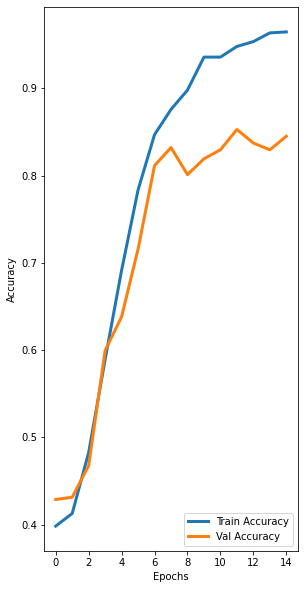

In [16]:
#gráfico del accurracy
f = plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.plot(history_conv.history['acc'], linewidth=3, label='Train Accuracy')
plt.plot(history_conv.history['val_acc'], linewidth=3, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.axis([0, 4, 0, 1])
plt.legend(loc='lower right')
plt.show()

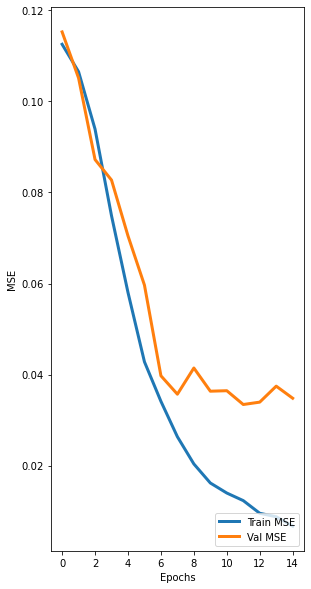

In [17]:
#gráfico del mse
f = plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.plot(history_conv.history['mse'], linewidth=3, label='Train MSE')
plt.plot(history_conv.history['val_mse'], linewidth=3, label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
#plt.axis([0, 4, 0, 0.1])
plt.legend(loc='lower right')
plt.show()

In [18]:
# Evaluar el modelo con el conjunto de prueba
loss, accuracy, mse = model_conv.evaluate(x_test, y_test, verbose=0)

# Imprimir la pérdida y las métricas
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test MSE:', mse)

Test loss: 0.6748413443565369
Test accuracy: 0.8449612259864807
Test MSE: 0.034807056188583374


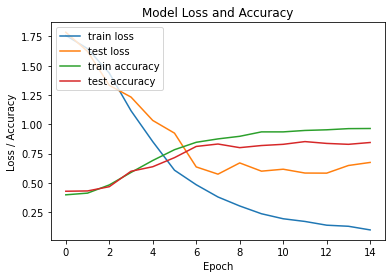

In [19]:
# Graficar la pérdida y el accuracy del modelo
plt.plot(history_conv.history['loss'], label='train loss')
plt.plot(history_conv.history['val_loss'], label='test loss')
plt.plot(history_conv.history['acc'], label='train accuracy')
plt.plot(history_conv.history['val_acc'], label='test accuracy')
plt.title('Model Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend(loc='upper left')
plt.show()

Faltaría:
- Agregar normalizado a los datos de entrada para mejorar el funcionamiento de la red.
- Agregar matriz de confusión para visualizar el resultado de la red de otra manera.